In [178]:
import mne
import os
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
from scipy.signal import resample
import random
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
from sklearn.utils import resample, shuffle
import matplotlib.patches as mpatches

In [93]:
#rename files to numbers instead of participant initials
'''participant = '002'
data_path = f'epochs/{participant}/'

for f in os.listdir(data_path):
    new_name = f.replace('SH', participant)
    print(new_name)
    os.rename(f'{data_path}{f}', f'{data_path}{new_name}') '''

"participant = '002'\ndata_path = f'epochs/{participant}/'\n\nfor f in os.listdir(data_path):\n    new_name = f.replace('SH', participant)\n    print(new_name)\n    os.rename(f'{data_path}{f}', f'{data_path}{new_name}') "

In [94]:
def count_labels(labels):
    
    neg = [l for l in labels if l <= 0]
    pos = [l for l in labels if l > 0]

    return [len(neg), len(pos)]

In [154]:
''' load data into dictionary '''
#import data
participant = '007'
data_path = f'epochs_2/{participant}/'
bands = ['Alpha', 'Beta', 'High-gamma', 'Theta', 'Gamma']

#get list of available files
files = [x for x in os.listdir(data_path) if '.npy' in x]
#filter for epoch files (leave out label file)
epoch_files = [x for x in files if 'labels' not in x]
#print(files)
data = {}

#find files containing windowed data
windowed_files = [x for x in files if '_w' in x]
windowed_data_files = [x for x in windowed_files if 'labels' not in x]
windowed_label_files = [x for x in windowed_files if 'labels' in x]
#print(windowed_labels)
#get windows (w0, w1, w2, etc)
windows = [w[w.index('_') + 1:w.index('_', w.index('_') + 2)] for w in windowed_files]# if w not in windows]
windows = list(dict.fromkeys(windows))
#print(windows)
#create dictionary to store data according to windows
windowed_data = {}
for w in windows:
    windowed_data[int(w[1])] = {'bands':{}, 'labels': {}, 'mask' : []} 
for file in windowed_files:
    #get window in integer ('w0' --> 0)
    file_window = int(file[file.find('w'):file.index('_', file.find('w'))][1])
    #check if its data or labels
    if 'labels.npy' in file:
        #save labels according to window 
        l = np.load(f'{data_path}{file}')
        l = l.astype(np.int32)
        windowed_data[file_window]['labels'] = l
    elif 'labels_masked' in file:
        lm = np.load(f'{data_path}{file}')
        windowed_data[file_window]['mask'] = lm
    else:
        #get frequency band from file 
        file_band = file[file.find('_', file.find('w')) + 1: file.find('.')]
        #add data to dict in the right window and band
        windowed_data[file_window]['bands'][file_band] = np.load(f'{data_path}{file}')
        #print(file_band)


In [155]:
print((windowed_data[2]['mask']))

[False False False False False False  True False False False  True  True
  True False False False False  True False False  True  True  True False
 False  True  True  True  True  True False  True  True  True False False
 False False False  True  True  True  True False False  True False  True
 False  True  True False  True False False  True  True  True  True False
 False  True False  True False  True False  True False  True  True False
  True False  True  True False  True  True False False  True False False
  True  True False False False False  True False False  True False False
 False  True False  True  True  True False  True False False]


In [156]:
''' filter out 0 ratings'''
#sanity check (almost clinically insane)
for window in windowed_data:
    print(f"\n--- Window: {window} ---")
    print('abels length ', len(windowed_data[window]['labels']))
    print('mask length  ', len(windowed_data[window]['mask']))
    for band in windowed_data[window]['bands']:
        print(f'band {band} shape: {windowed_data[window]['bands'][band].shape}')

#print(len(zero_mask_0),len(zero_mask_1),len(zero_mask_2),len(zero_mask_3))
for window in windowed_data:
    #get 0 trials for per window (cant guarantee theyre all the same)
    zero_mask = (windowed_data[window]['labels'] == 0)
    print(window, len(zero_mask))
    windowed_data[window]['mask'] = windowed_data[window]['mask'][~zero_mask]
    windowed_data[window]['labels'] = windowed_data[window]['labels'][~zero_mask]
    for band in windowed_data[window]['bands']:
        data = windowed_data[window]['bands'][band]
        windowed_data[window]['bands'][band] = data[~zero_mask]
        #print(windowed_data[window]['bands'][band].shape)


#assign 0 for negative and 1 for positive values
for window in windowed_data:
    labels = windowed_data[window]['labels']
    #print(labels)
    labels_zerod = [1 if x > 0 else 0 for x in labels]
    windowed_data[window]['labels'] = labels_zerod


--- Window: 0 ---
abels length  106
mask length   106
band Alpha shape: (106, 19)
band Beta shape: (106, 19)
band Delta shape: (106, 19)
band Gamma shape: (106, 19)
band High-gamma shape: (106, 19)
band Theta shape: (106, 19)

--- Window: 1 ---
abels length  106
mask length   106
band Alpha shape: (106, 19)
band Beta shape: (106, 19)
band Delta shape: (106, 19)
band Gamma shape: (106, 19)
band High-gamma shape: (106, 19)
band Theta shape: (106, 19)

--- Window: 2 ---
abels length  106
mask length   106
band Alpha shape: (106, 19)
band Beta shape: (106, 19)
band Delta shape: (106, 19)
band Gamma shape: (106, 19)
band High-gamma shape: (106, 19)
band Theta shape: (106, 19)

--- Window: 3 ---
abels length  106
mask length   106
band Alpha shape: (106, 19)
band Beta shape: (106, 19)
band Delta shape: (106, 19)
band Gamma shape: (106, 19)
band High-gamma shape: (106, 19)
band Theta shape: (106, 19)
0 106
1 106
2 106
3 106


In [157]:
windowed_data[3]['bands']['Alpha'].shape

(92, 19)

In [158]:
''' balancing
for window in windowed_data: 
    Y = windowed_data[window]['labels']
    for band in windowed_data[window]['bands']:
    #data 
        X = windowed_data[window]['bands'][band]
        x_re, y_re = SMOTE().fit_resample(X, Y)
        print(x_re.shape, len(y_re), window, band)
        windowed_data[window]['bands'][band] = x_re
        windowed_data[window]['labels'] = np.array(y_re)  
        
print(count_labels(y_re))
print(x_re.shape, len(y_re))
print(windowed_data[1]['bands']['Alpha'].shape)

'''

" balancing\nfor window in windowed_data: \n    Y = windowed_data[window]['labels']\n    for band in windowed_data[window]['bands']:\n    #data \n        X = windowed_data[window]['bands'][band]\n        x_re, y_re = SMOTE().fit_resample(X, Y)\n        print(x_re.shape, len(y_re), window, band)\n        windowed_data[window]['bands'][band] = x_re\n        windowed_data[window]['labels'] = np.array(y_re)  \n\nprint(count_labels(y_re))\nprint(x_re.shape, len(y_re))\nprint(windowed_data[1]['bands']['Alpha'].shape)\n\n"

In [159]:
data = windowed_data[0]['bands']['Alpha']
labels = windowed_data[0]['labels']

In [160]:
clf = LinearDiscriminantAnalysis()
sKfold = StratifiedKFold(n_splits = 7)
print("window\t\tband\t\taccuracy\tmean auc\tp")
data = []
data_auc = []
statistics = []
auc_collection = {}
n_perm = 1000
for window in windowed_data:
    preY = windowed_data[window]['labels']
    Y = np.array(preY)
    auc_collection[window] = {}
    #print(Y.shape)
    for band in windowed_data[window]['bands']:
        X = windowed_data[window]['bands'][band]
        auc_collection[window][band] = []
        #print(X.shape)
        acc_mean = []
        auc_mean = []
        for train, test in sKfold.split(X, Y):

            X_train, Y_train = X[train], Y[train]
            
            #train,test = np.array(train), np.array(test)
            #print(train, test)
            #find majority/minortiy
            class_0 = np.where(Y[train] == 0)[0]
            class_1 = np.where(Y[train] == 1)[0]

            if len(class_0) > len(class_1):
                class_major, class_minor = class_0, class_1
            else:
                class_major, class_minor = class_1, class_0

            upsample_minor = resample(class_minor, replace=True, n_samples=len(class_major))

            #combine/shuffle
            resampled_indices = np.concatenate([class_major, upsample_minor])
            np.random.shuffle(resampled_indices)
            X_train_balanced = X_train[resampled_indices]
            Y_train_balanced = Y_train[resampled_indices]
            
            #print(Y[train].shape)
            #print(f'train -  {count_labels(Y[train])}   |   test -  {count_labels(Y[test])}')
            #clf.fit(X[train], Y[train])
            clf.fit(X_train_balanced, Y_train_balanced)
            pred = clf.predict(X[test])
            y_prob = clf.predict_proba(X[test])[:,1]
            fpr, tpr, thresholds = roc_curve(Y[test], y_prob)
            roc_auc = auc(fpr, tpr)
            auc_mean.append(roc_auc)
            acc_mean.append(accuracy_score(Y[test], pred))
            auc_collection[window][band].append(roc_auc)
            #print(f'accuracy window {window} band {band}', accuracy_score(Y[test], pred))
            #print('conf matrix\n', confusion_matrix(Y, pred))
            #print('classification report', classification_report(Y, pred))
        mean = sum(acc_mean) / len(acc_mean)
        mean_auc = sum(auc_mean) / len(auc_mean)

        #permutation test
        perm_auc_scores = []
        for _ in range(n_perm):
            Y_perm = shuffle(Y, random_state=None)
            perm_aucs = []
            #perm_auc_scores = []
            for train, test in sKfold.split(X, Y_perm):

                X_train_perm, Y_train_perm = X[train], Y_perm[train]
                class_0 = np.where(Y_train_perm == 0)[0]
                class_1 = np.where(Y_train_perm == 1)[0]

                if len(class_0) > len(class_1):
                    class_major, class_minor = class_0, class_1
                else:
                    class_major, class_minor = class_1, class_0

                upsample_minor = resample(class_minor, replace=True, n_samples=len(class_major))
                resampled_indices = np.concatenate([class_major, upsample_minor])
                np.random.shuffle(resampled_indices)

                X_train_bal = X_train_perm[resampled_indices]
                Y_train_bal = Y_train_perm[resampled_indices]

                clf.fit(X_train_bal, Y_train_bal)
                y_prob = clf.predict_proba(X[test])[:, 1]
                fpr, tpr, _ = roc_curve(Y_perm[test], y_prob)
                perm_aucs.append(auc(fpr, tpr))

            perm_auc_scores.append(np.mean(perm_aucs))

        p_value = np.mean(np.array(perm_auc_scores) >= mean_auc)
        data_to_save_acc = [window, band, mean]
        data.append(data_to_save_acc)
        data_auc.append([window, band, mean_auc])
        print(f"{window}\t\t{band}\t\t{mean:.3f}\t\t{mean_auc:.3f}\t\t{p_value:.4f}")
        statistics.append({
            'window': window,
            'band': band,
            'accuracy': mean,
            'mean_auc': mean_auc,
            'p_value': p_value
        })
    print('=' * 60)
    
df_results = pd.DataFrame(statistics)
df_results.to_csv(f'figures_2/classification_results_with_permutation_{participant}.csv', index=False)
    
print("\n✅ Results saved to 'classification_results_with_permutation.csv'")

window		band		accuracy	mean auc	p
0		Alpha		0.642		0.656		0.0410
0		Beta		0.542		0.513		0.4850
0		Delta		0.564		0.467		0.6890
0		Gamma		0.597		0.545		0.3570
0		High-gamma		0.512		0.432		0.8430
0		Theta		0.575		0.460		0.7070
1		Alpha		0.586		0.535		0.4140
1		Beta		0.622		0.663		0.0310
1		Delta		0.586		0.461		0.7040
1		Gamma		0.502		0.467		0.7380
1		High-gamma		0.609		0.515		0.5120
1		Theta		0.599		0.562		0.2890
2		Alpha		0.673		0.498		0.5280
2		Beta		0.521		0.512		0.4970
2		Delta		0.567		0.430		0.8000
2		Gamma		0.501		0.455		0.7180
2		High-gamma		0.619		0.423		0.8620
2		Theta		0.531		0.429		0.8450
3		Alpha		0.465		0.363		0.9490
3		Beta		0.542		0.512		0.4820
3		Delta		0.531		0.359		0.9630
3		Gamma		0.531		0.383		0.9210
3		High-gamma		0.498		0.454		0.7360
3		Theta		0.630		0.574		0.2420

✅ Results saved to 'classification_results_with_permutation.csv'


In [ ]:
data_auc

    window        band  accuracy
0        0       Alpha  0.642072
1        0        Beta  0.541601
2        0       Delta  0.564364
3        0       Gamma  0.597331
4        0  High-gamma  0.511774
5        0       Theta  0.574568
6        1       Alpha  0.585557
7        1        Beta  0.622449
8        1       Delta  0.585557
9        1       Gamma  0.501570
10       1  High-gamma  0.609105
11       1       Theta  0.598901
12       2       Alpha  0.672684
13       2        Beta  0.521193
14       2       Delta  0.566719
15       2       Gamma  0.500785
16       2  High-gamma  0.618524
17       2       Theta  0.531397
18       3       Alpha  0.464678
19       3        Beta  0.542386
20       3       Delta  0.531397
21       3       Gamma  0.530612
22       3  High-gamma  0.497645
23       3       Theta  0.629513


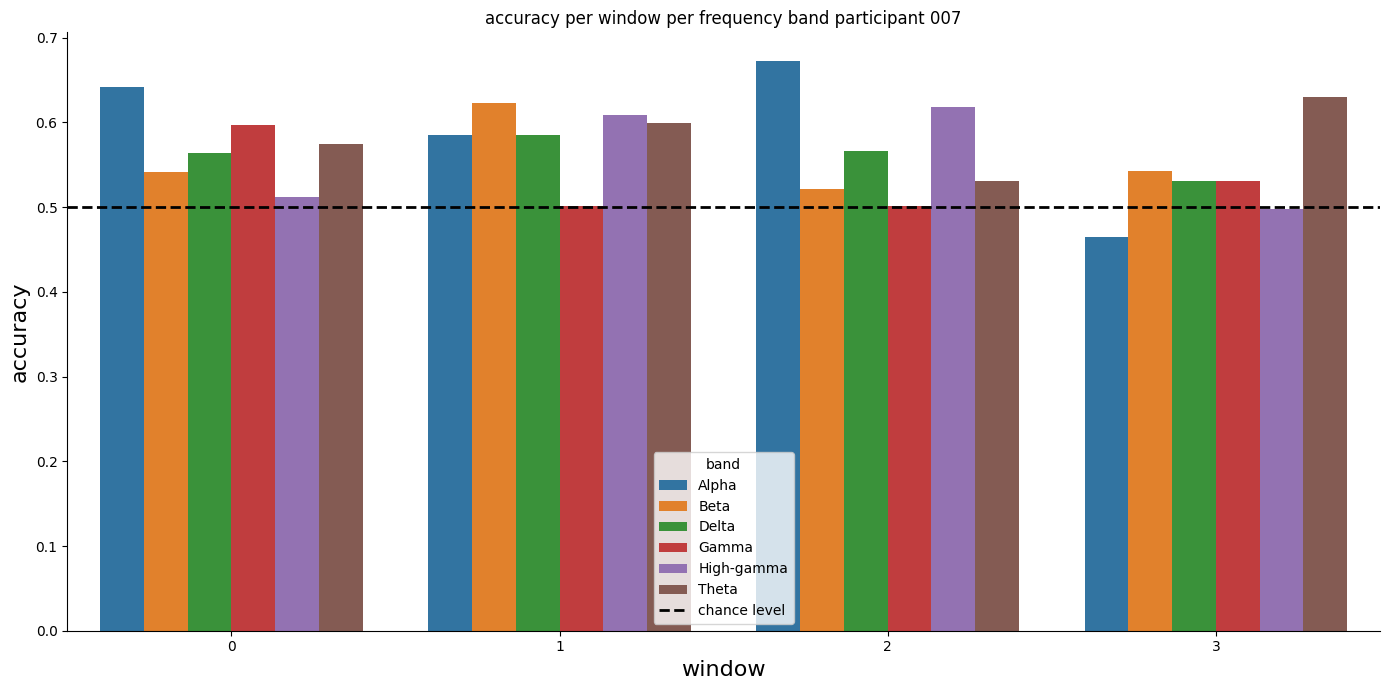

In [161]:
df = pd.DataFrame(data, columns=['window', 'band', 'accuracy'])
print(df)

plt.figure(figsize=(14,7))
ax = sns.barplot(data=df, x='window', y='accuracy', hue='band')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='chance level')
    
plt.title(f'accuracy per window per frequency band participant {participant}')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('window', fontsize=16)
plt.legend(title='band')
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_position(('outward', 100))  # Add padding to the bottom
ax.spines['right'].set_position(('outward', 100)) 
plt.savefig(f'figures_2/accuracy_windows_{participant}.png', dpi=300, bbox_inches='tight')
plt.show()

    window        band       AUC
0        0       Alpha  0.655556
1        0        Beta  0.512698
2        0       Delta  0.466667
3        0       Gamma  0.545238
4        0  High-gamma  0.431746
5        0       Theta  0.459921
6        1       Alpha  0.534921
7        1        Beta  0.663095
8        1       Delta  0.460714
9        1       Gamma  0.467460
10       1  High-gamma  0.515476
11       1       Theta  0.562302
12       2       Alpha  0.498016
13       2        Beta  0.511508
14       2       Delta  0.430159
15       2       Gamma  0.455159
16       2  High-gamma  0.423413
17       2       Theta  0.428968
18       3       Alpha  0.363095
19       3        Beta  0.511508
20       3       Delta  0.359127
21       3       Gamma  0.383333
22       3  High-gamma  0.453571
23       3       Theta  0.573810


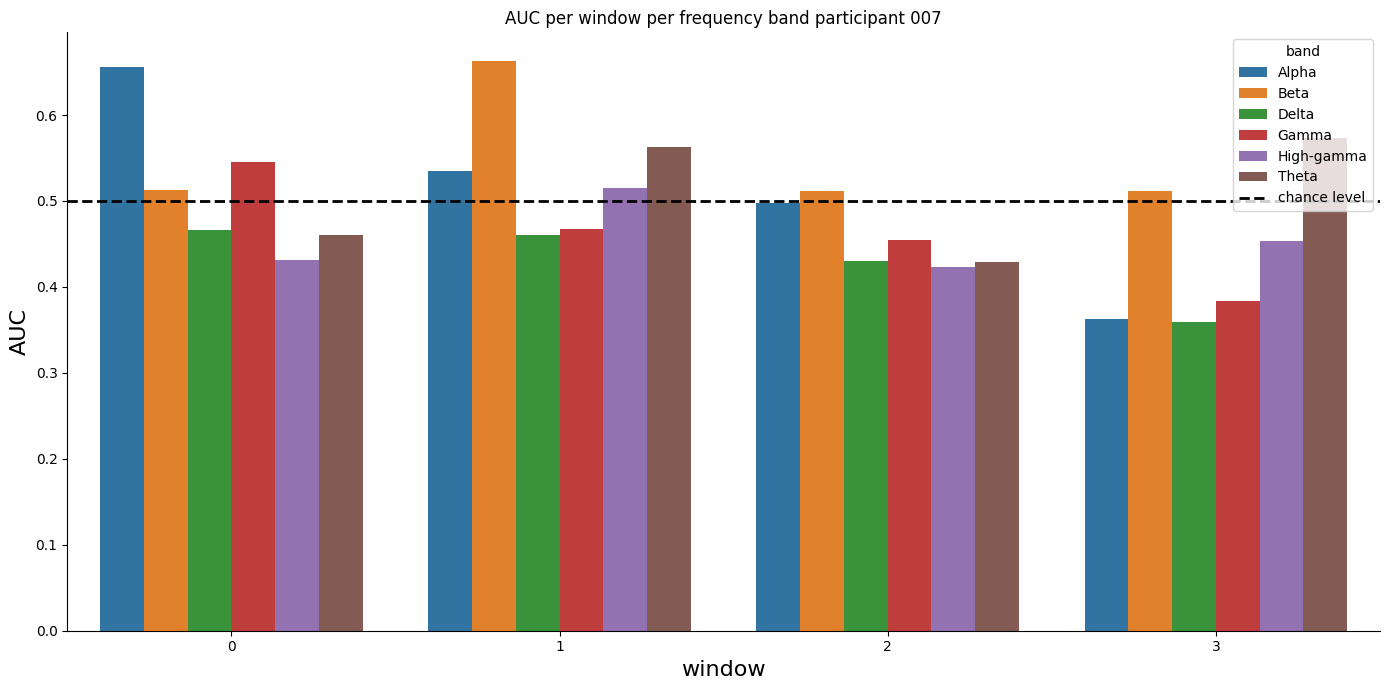

In [162]:
df = pd.DataFrame(data_auc, columns=['window', 'band', 'AUC'])
print(df)

plt.figure(figsize=(14,7))
ax = sns.barplot(data=df, x='window', y='AUC', hue='band')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='chance level')
    
plt.title(f'AUC per window per frequency band participant {participant}')
plt.ylabel('AUC', fontsize=16)
plt.xlabel('window', fontsize=16)
plt.legend(title='band')
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_position(('outward', 100))  # Add padding to the bottom
ax.spines['right'].set_position(('outward', 100)) 
plt.savefig(f'figures_2/AUC_windows_{participant}.png', dpi=300, bbox_inches='tight')
plt.show()

['Alpha', 'Beta', 'Theta', 'Gamma', 'High-gamma', 'Alpha trend', 'Beta trend', 'Theta trend', 'Gamma trend', 'High-gamma trend']


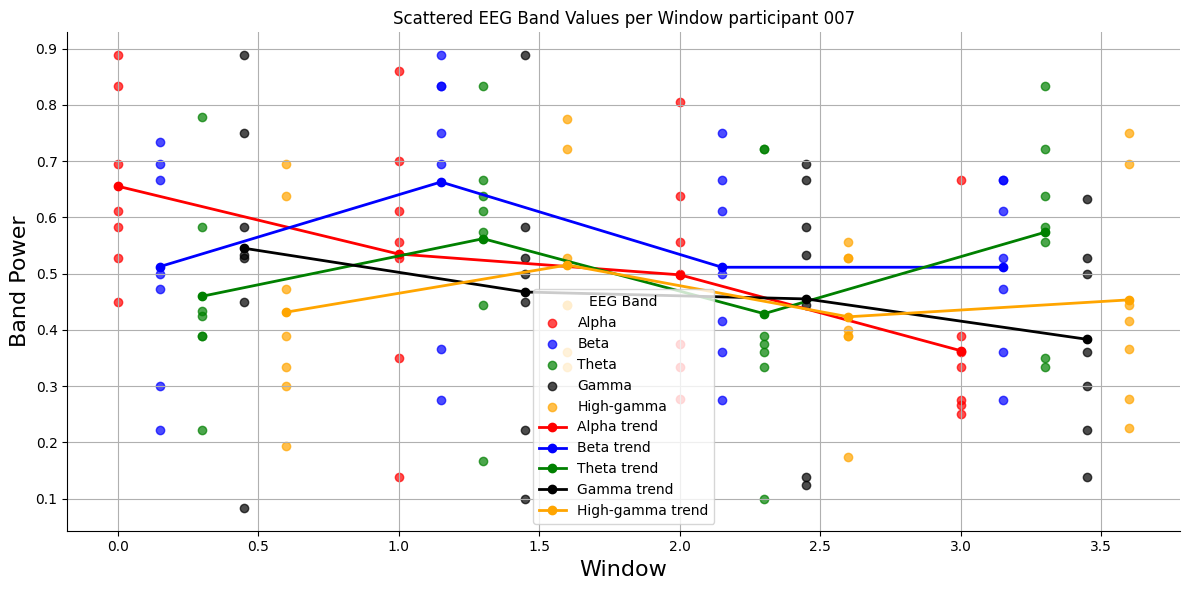

In [163]:
#graph auc increase over time/during windows

bands = ['Alpha', 'Beta', 'Theta', 'Gamma', 'High-gamma']
colors = {'Alpha': 'red', 'Beta' : 'blue', 'Theta' : 'green', 'Gamma' : 'black', 'High-gamma' : 'orange'}

fig, ax = plt.subplots(figsize=(12,6))

band_offsets = {band: i * 0.15 for i, band in enumerate(bands)}
window_ids = sorted(auc_collection.keys())

for window, band_values in auc_collection.items():
    for band in bands:
        x_vals = [window + band_offsets[band]] * len(band_values[band])
        y_vals = band_values[band]
        ax.scatter(x_vals, y_vals, label=band if window == 0 else "", color=colors[band], alpha=0.7)
for band in bands:
    mean_vals = [np.mean(auc_collection[win][band]) for win in window_ids]
    #print(mean_vals)
    ax.plot([win + band_offsets[band] for win in window_ids], mean_vals, color=colors[band], linewidth=2, marker='o', label=f'{band} trend')

ax.set_xlabel('Window', fontsize=16)
ax.set_ylabel('Band Power', fontsize=16)
ax.set_title(f'Scattered EEG Band Values per Window participant {participant}')
handles, labels = ax.get_legend_handles_labels()
#print(labels[:6])
by_label = dict(zip(labels, handles))
print(list(by_label))
ax.legend(by_label.values(), by_label.keys(), title='EEG Band')
#ax.legend()
ax.grid(True)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_position(('outward', 100))  # Add padding to the bottom
ax.spines['right'].set_position(('outward', 100)) 
plt.savefig(f'figures_2/mean_auc_scattered_{participant}.png', dpi=300, bbox_inches='tight')
plt.show()

In [105]:
#https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py

In [ ]:
#mean auc for all participants



Index(['window', 'band', 'mean', 'std'], dtype='object')
Index(['window', 'band', 'mean', 'std'], dtype='object')
Index(['window', 'band', 'mean', 'std'], dtype='object')
Index(['window', 'band', 'mean', 'std'], dtype='object')


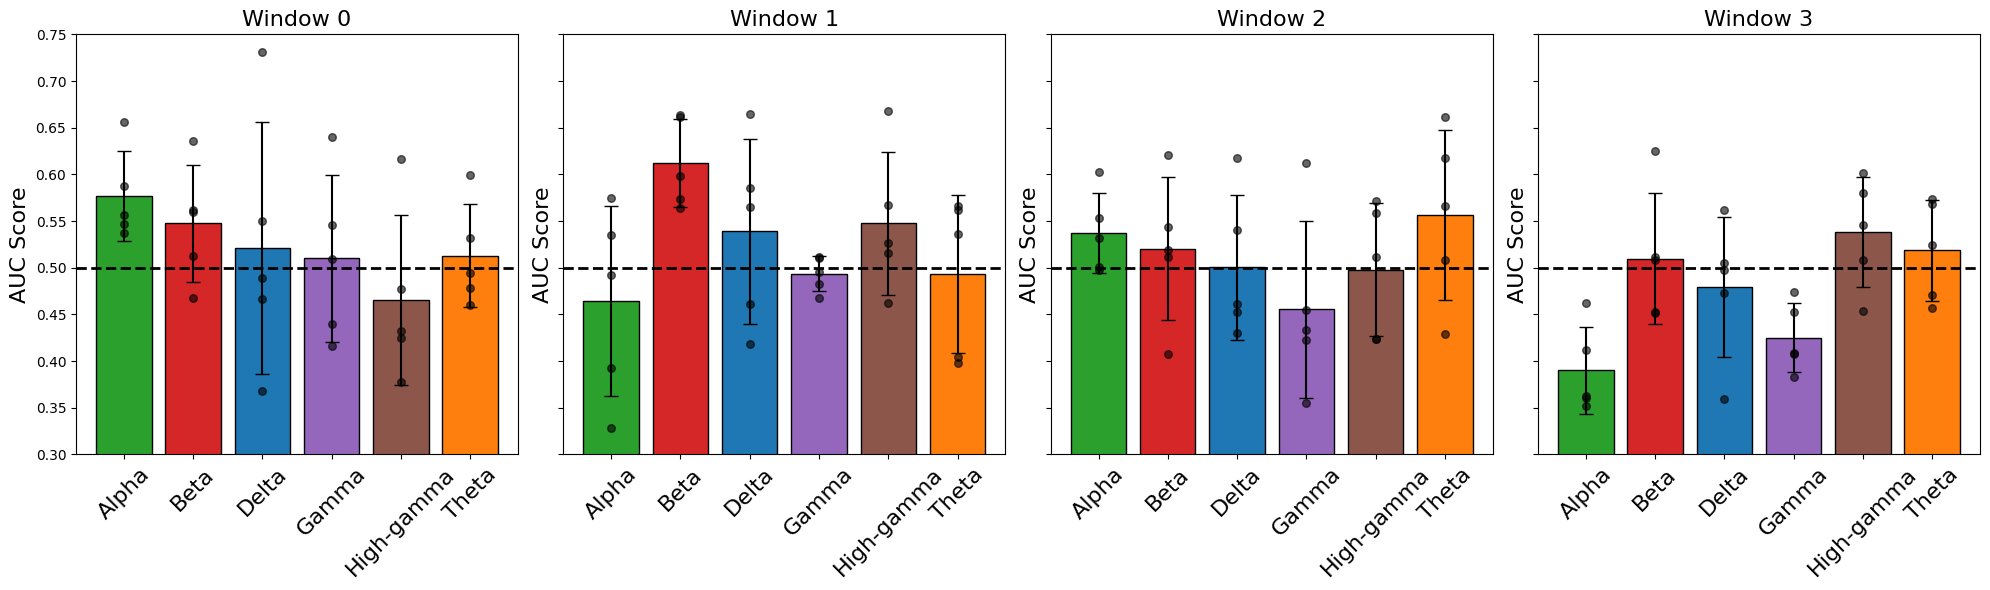

In [206]:
#auc per band per participant
path = 'figures_2/'
files = os.listdir(path)
csv_files = [f'{path}{x}' for x in files if x.endswith('.csv')]

df_list=[]
for file in csv_files:
    df = pd.read_csv(file)
    participant_id = file.split('_')[-1].split('.')[0]
    df['participant'] = participant_id
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
mean_auc = mean_auc = combined_df.groupby(['window', 'band'])['mean_auc'].mean().reset_index()
agg_df = combined_df.groupby(['window', 'band'])['mean_auc'].agg(['mean', 'std']).reset_index()

windows = sorted(combined_df['window'].unique())
fig, axes = plt.subplots(nrows=1, ncols=len(windows), figsize=(5 * len(windows), 6), sharey=True)

if len(windows) == 1:
    axes = [axes]

band_colors = {
    'Delta': '#1f77b4',       
    'Theta': '#ff7f0e',      
    'Alpha': '#2ca02c',     
    'Beta': '#d62728',      
    'Gamma': '#9467bd',      
    'High-gamma': '#8c564b'  
}

for ax, window in zip(axes, windows):
    data = agg_df[agg_df['window'] == window]
    print(data.columns)
    x = np.arange(len(data['band']))
    
    bar_colors = [band_colors.get(band, 'gray') for band in data['band']]

    ax.bar(
        x,
        data['mean'],
        yerr=data['std'],
        capsize=5,
        color=bar_colors,
        edgecolor='black'
    )
    

    for i, band in enumerate(data['band']):
        band_scores = combined_df[(combined_df['window'] == window) & (combined_df['band'] == band)]
        ax.scatter(
            np.full(len(band_scores), i),
            band_scores['mean_auc'],
            alpha=0.6,
            label=None,
            color='black',
            s=30
        )
    #for j, (mean, p_val) in enumerate(zip(data['mean'], data['p_value'])):
    #    if p_val < 0.05:
    #        ax.text(x[j], mean + 0.02, '*', ha='center', va='bottom', color='red', fontsize=14)
    ax.axhline(0.5, color='black', linestyle='--', linewidth=2)

    '''for j, band in enumerate(bands):
        band_scores = combined_df[(combined_df['window'] == window) & (combined_df['band'] == band)]
        mean_auc_val = band_scores['mean_auc'].mean()
        p_val = band_scores['p_value'].mean()

        if p_val < 0.05:
            print(p_val)
            ax.text(j, mean_auc_val + 0.03, '*', ha='center', va='bottom', color='red', fontsize=16)'''

    for j, band in enumerate(bands):
        band_scores = combined_df[(combined_df['window'] == window) & (combined_df['band'] == band)]
        mean_auc_val = band_scores['mean_auc'].mean()
        if 'p_value' in band_scores.columns:
            p_val = band_scores['p_value'].mean()
            if p_val < 0.05:
                print(p_val)
                ax.text(j, 0.7, '*', ha='center', va='bottom', color='red', fontsize=16)


    ax.set_title(f'Window {window}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(data['band'], rotation=45, fontsize=16)
    ax.set_ylim(0.3, 0.75)
    ax.set_ylabel('AUC Score', fontsize=16)
    legend_handles = [mpatches.Patch(color=color, label=band) for band, color in band_colors.items()]
    #fig.legend(handles=legend_handles, loc='upper right')
#plt.ylim(0.4, 0.8)
#plt.savefig(f'figures_2/mean_auc_all_windows_.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Index(['window', 'band', 'mean', 'std'], dtype='object')
